In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt
from sklearn import metrics

## Read the Datasets

In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
df.shape

(28619, 3)

In [4]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [5]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [6]:
#Check for any null values int he dataset
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# Check for any duplicate rows

In [8]:
df['article_link'].nunique()

28617

In [9]:
#There are 2 duplicate rows
df.duplicated().sum()

2

In [10]:
#Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(inplace=True)

In [11]:
#No duplicated found
df.duplicated().sum()

0

## Data Cleaning

## Step 1:
### Remove Special Characters
### Check if numbers are required
### Remove anomalies like 1a 2b

In [12]:
%%time
df1=df.copy()

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"[^\w\s]"," ",str(x)))

#Remove all numbers
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d',"",str(x)))

#Remove word anomalies
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d{1}[a-z]',"",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 278 ms


## Step 2:
### Convert to lower case
### Remove Stopwords and special words that need to be removed
### Perform Lemmatization

In [13]:
%%time
stop=set(stopwords.words('english'))
#Update any words that we want to remove here
custom_list=['nan']
stop.update(custom_list)

tadDict = defaultdict(lambda : wn.NOUN)
tadDict['J'] = wn.ADJ
tadDict['V'] = wn.VERB
tadDict['R'] = wn.ADV

#Convert to lower case
df1['headline']=df1['headline'].apply(lambda x: x.lower())

#Remove stopwords
# df1['headline']=df1['headline'].apply(lambda x: " ".join([i for i in word_tokenize(x) if i.casefold() not in map(str.casefold,stop)]))

#Perform Lemmatization
df1['headline']=df1['headline'].apply(lambda x: " ".join(WordNetLemmatizer().lemmatize(word,tadDict[tag[0]]) for word,tag in pos_tag(word_tokenize(x))))

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"( [a-z]{1} )|(^[a-z]{1} )|( [a-z]{1}$)"," ",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 46.3 s


In [14]:
df_cleaned=df1.copy()

In [15]:
df['headline'][7]

"richard branson's global-warming donation nearly as much as cost of failed balloon trips"

In [16]:
df_cleaned['headline'][7]

'richard branson global warm donation nearly as much cost of failed balloon trip'

In [17]:
# Removing records that are having Null after cleaning.
df_cleaned=df_cleaned[df_cleaned['headline'].apply(lambda x: len(x)) > 0]

In [18]:
from collections import Counter
corpus=" ".join(df_cleaned['headline'])
corpus_split=corpus.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(4)
most_occur

[('to', 9107), ('of', 6295), ('the', 5535), ('in', 4599)]

### Create Word Embeddings using Word2Vec

In [19]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities

from gensim.models import Word2Vec
from multiprocessing import cpu_count

In [20]:
def read_corpus(df):
    for i in df['headline']:
        tokens=gensim.utils.simple_preprocess(i)
        yield tokens
    
train_corpus=list(read_corpus(df_cleaned))

In [21]:
size=200
model=gensim.models.word2vec.Word2Vec(size=size,min_count=1,hs=1,sg=1,window=8,workers=cpu_count())
model.init_sims(replace=True)

model.build_vocab(train_corpus)
model.train(train_corpus,total_examples=model.corpus_count,epochs=model.epochs)

(1241522, 1411750)

### Creating Sentence Vectors

Word2Vec gives us embeddings for a particular word. But we need to embedding for whole sentence(s).

So, to convert the embedding for word to sentence we take the sum of all the words present in a sentence and divide it by the total number of unique words in that sentence. It is like taking average vector for the whole sentence using each vector of the word.

    For each row or sentence:
        - Append all the word vectors to form a matrix with size (# of words,vector size)
        - Take column wise sum of the matrix created
        - Divide the sum by number of the unique words in that row or sentence

In [22]:
def sentence_vector(sentence,model):
    sent_vec=[]
    for i in sentence:
        aa=[]
        tokens=gensim.utils.simple_preprocess(i)
        nunique_words=len(set(i.split()))
        for j in tokens:
            aa.append(model.wv[j])
        bb=pd.DataFrame(aa)
        cc=bb.sum(axis=0)/nunique_words
        sent_vec.append(cc)
    
    return pd.DataFrame(sent_vec)

In [23]:
%%time
headlines_vec=sentence_vector(df_cleaned['headline'],model)
min_max_scaler = preprocessing.MinMaxScaler()
headlines_vec = min_max_scaler.fit_transform(headlines_vec)
headlines_vec.shape

Wall time: 5min 23s


(28617, 200)

In [24]:
is_sarcastic=df_cleaned['is_sarcastic']

## Creating Test Training Split

In [25]:
#training and test data splits
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(headlines_vec, is_sarcastic, test_size = 0.25, random_state = 0)

In [26]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(21462, 200)
(7155, 200)
(21462,)
(7155,)


# Classification Task

## Naive Bayes classifier

In [27]:
#Naive Bayes classifier
def test_NaiveBayes(x_train, x_test, y_train, y_test):
    MNB = GaussianNB()
    NBClassifier = MNB.fit(x_train, y_train)
    predictions = NBClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [28]:
%%time
#Tesiting Naive-Bayes classifier
accuracy, precision, recall, f1 = test_NaiveBayes(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.76617749825297
Precision= 0.7712038538016732
Recall   = 0.76617749825297
F1 Score = 0.766128453092362
Wall time: 142 ms


## Logistic Regression Classifier

In [40]:
from sklearn.linear_model import LogisticRegression
def test_LogisticRegression(x_train, x_test, y_train, y_test):
    model = LogisticRegression(class_weight='balanced',solver="liblinear",max_iter=300, C=1e7)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [41]:
%%time
#Tesiting Logistic Regression classifier
accuracy, precision, recall, f1 = test_LogisticRegression(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.8018169112508735
Precision= 0.8030974587204962
Recall   = 0.8018169112508735
F1 Score = 0.801961051186035
Wall time: 22.4 s


## Multilayer Perceptron classfier

In [32]:
#Multilayer Perceptron classfier
def test_NN(x_train, x_test, y_train, y_test):
    NN = MLPClassifier(solver = 'adam', alpha = 0.00095, learning_rate = 'adaptive', learning_rate_init = 0.01, max_iter = 300, random_state = 0)
    Perceptron = NN.fit(x_train, y_train)
    predictions = Perceptron.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [33]:
%%time
#Testing NN classifier
accuracy, precision, recall, f1 = test_NN(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.797204751921733
Precision= 0.7978915898674603
Recall   = 0.797204751921733
F1 Score = 0.796572427359978
Wall time: 16 s


## SVM classifier

In [34]:
#SVM classifier
def test_SVM(x_train, x_test, y_train, y_test):
    SVM = SVC(kernel = 'linear')
    SVMClassifier = SVM.fit(x_train, y_train)
    predictions = SVMClassifier.predict(x_test)
    a = accuracy_score(y_test, predictions)
    p = precision_score(y_test, predictions, average = 'weighted')
    r = recall_score(y_test, predictions, average = 'weighted')
    f = f1_score(y_test, predictions, average = 'weighted')
    return a, p, r, f

In [35]:
%%time
#Testing SVM classifier
accuracy, precision, recall, f1 = test_SVM(x_train, x_test, y_train, y_test)
print("Accuracy =",accuracy)
print("Precision=",precision)
print("Recall   =",recall)
print("F1 Score =",f1)

Accuracy = 0.7976240391334731
Precision= 0.7984333483495465
Recall   = 0.7976240391334731
F1 Score = 0.7977572702712377
Wall time: 1min 24s


## Extreme Learning Machine (ELM)

In [36]:
%%time
input_size = x_train.shape[1]
hidden_size = 1000
input_weights = np.random.uniform(low=0, high=1,size=[input_size,hidden_size])
biases = np.random.uniform(low=0, high=1,size=[hidden_size])

def relu(x):
    return np.maximum(x, 0, x)

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(np.linalg.pinv(hidden_nodes(x_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(x_test)
# Applying Sigmoidal Activation function
y_pred=[1/(1+np.exp(-x)) for x in prediction]

Wall time: 6.12 s


In [37]:
acc=[]
prec=[]
rec=[]
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]:
    y_pred=[1 if x>=i else 0 for x in prediction]
    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    rec.append(metrics.recall_score(y_test, y_pred))

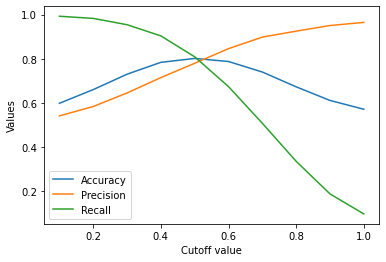

In [38]:
plt.plot(np.arange(0.1,1.1,0.1),acc,label="Accuracy")
plt.plot(np.arange(0.1,1.1,0.1),prec,label="Precision")
plt.plot(np.arange(0.1,1.1,0.1),rec,label="Recall")
plt.xlabel('Cutoff value')
plt.ylabel('Values')
plt.legend()
plt.show()

In [39]:
y_pred=[1 if x>=0.5 else 0 for x in prediction]

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

# Model F1-Score
print("F1-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.8013976240391335
Precision: 0.779549985759043
Recall: 0.808806146572104
F1-Score: 0.7939086294416244
